# **Early Analysis & Insights For Fair Use Cases Data**

**Project Milestone 2**

**Team:** B1 Team 13

**Team Member:** Mohamad Gong

# Introduction

This project analyzes a public dataset of U.S. fair use decisions collected from the U.S. Copyright Office’s Fair Use Index and distributed via TidyTuesday. Data and documentation are available here:
https://github.com/rfordatascience/tidytuesday/tree/main/data/2023/2023-08-29

Copyright claims can be used to pressure people into removing lawful criticism, commentary, and educational content because disputes are costly and uncertain. Unclear fair use boundaries also harm good-faith creators by weakening protection of original work and income; high-profile disputes such as *Lenz v. Universal* and *Warhol Foundation v. Goldsmith* illustrate ongoing uncertainty around fair use and “transformative” use. Our broader goal is to use unsupervised learning to surface repeatable patterns across cases and make precedent easier to navigate, supporting decisions to push back, license, or escalate. Key stakeholders include creators and small businesses, media and education organizations, platforms and policy teams handling disputes at scale, and legal, insurance, and advocacy groups.

The dataset contains written summaries of each case’s key facts, the fair use issue, and the court’s holding, along with tags and structured metadata. In the team’s proposal, we noted that merges across tables can be unreliable because case identifiers are not standardized; accordingly, this notebook focuses on the `fair_use_findings` table as the primary analysis unit.

This notebook addresses the team’s Question 2, venue fairness after controlling for dispute type. Specifically, after grouping cases into comparable case types using tags, categories, and recurring text themes, do some courts or circuits remain consistently more creator-friendly versus rightsholder-friendly for the same case type?

Prior EDA suggested that outcomes are imbalanced, the dataset is dominated by a few courts and circuits, and tags may mix what the case is about with where it was decided. The text fields also vary substantially in length, and legal language can be generic, so the analysis emphasizes text features that separate cases by facts and themes rather than boilerplate.

The sections that follow first present updated EDA for `fair_use_findings`, including outcome distributions and tag and category structure. The notebook then applies unsupervised text methods to extract dispute themes and group cases into comparable case types, and finally compares fair use outcomes across venues within those types.

# Setting Up Environment

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Data Importing, Inspection and Preparation

## Data Importing

In [76]:
fair_use_cases = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2023/2023-08-29/fair_use_cases.csv')
fair_use_findings = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2023/2023-08-29/fair_use_findings.csv')

## Data Inspection

### Fair Use Cases Table

The `fair_use_cases` table provides one row per case with structured metadata such as year, court, jurisdiction, content categories, and a binary indicator for whether fair use was found. Inspection focuses on confirming completeness, consistency of categorical fields, and suitability for comparing outcomes across courts, categories, and time.

| variable       | class     | description                                                                                                   |
| -------------- | --------- | ------------------------------------------------------------------------------------------------------------- |
| case           | character | The name and number of the case.                                                                              |
| year           | integer   | The year in which the case was decided.                                                                       |
| court          | character | The court in which the ruling was made.                                                                       |
| jurisdiction   | character | The jurisdiction of that court.                                                                               |
| categories     | character | A comma- or semicolon-separated list of categories to which the case belongs. These have not been normalized. |
| outcome        | character | A string describing the outcome of the case.                                                                  |
| fair_use_found | logical   | Whether fair use was found by the court. FALSE might sometimes indicate a more complicated finding.           |

In [77]:
print("Dataset Info:")
print(fair_use_cases.info())

print("\nFirst 5 rows:")
print(fair_use_cases.head())

print("\nMissing Values:")
print(fair_use_cases.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   case            251 non-null    object
 1   year            251 non-null    int64 
 2   court           251 non-null    object
 3   jurisdiction    251 non-null    object
 4   categories      251 non-null    object
 5   outcome         251 non-null    object
 6   fair_use_found  251 non-null    bool  
dtypes: bool(1), int64(1), object(5)
memory usage: 12.1+ KB
None

First 5 rows:
                                                case  year        court  \
0  De Fontbrune v. Wofsy, 39 F.4th 1214 (9th Cir....  2022  9th Circuit   
1  Sedlik v. Von Drachenberg, No. CV 21-1102 (C.D...  2022    C.D. Cal.   
2  Sketchworks Indus. Strength Comedy, Inc. v. Ja...  2022     S.D.N.Y.   
3  Am. Soc'y for Testing & Materials v. Public.Re...  2022       D.D.C.   
4  Yang v. Mic Network Inc., No

### Fair Use Findings Table

The `fair_use_findings` table contains complementary case-level text, including summaries of key facts, legal issues, holdings, and descriptive tags. Inspection centers on text completeness and variability, as these fields support later analysis of language patterns, similarity, and thematic structure across cases.

| variable    | class     | description                                                                            |
| ----------- | --------- | -------------------------------------------------------------------------------------- |
| title       | character | The title of the case.                                                                 |
| case_number | character | The case number or numbers of the case.                                                |
| year        | character | The year in which the finding was made (or findings were made).                        |
| court       | character | The court or courts involved.                                                          |
| key_facts   | character | The key facts of the case.                                                             |
| issue       | character | A brief description of the fair use issue.                                             |
| holding     | character | The decision of the court in paragraph form.                                           |
| tags        | character | Comma- or semicolon-separated tags for this case.                                      |
| outcome     | character | A brief description of the outcome of the case. These fields have not been normalized. |

In [78]:
print("Dataset Info:")
print(fair_use_findings.info())

print("\nFirst 5 rows:")
print(fair_use_findings.head())

print("\nMissing Values:")
print(fair_use_findings.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        251 non-null    object
 1   case_number  251 non-null    object
 2   year         251 non-null    object
 3   court        251 non-null    object
 4   key_facts    251 non-null    object
 5   issue        251 non-null    object
 6   holding      251 non-null    object
 7   tags         251 non-null    object
 8   outcome      251 non-null    object
dtypes: object(9)
memory usage: 17.8+ KB
None

First 5 rows:
                                               title  \
0                              De Fontbrune v. Wofsy   
1                          Sedlik v. Von Drachenberg   
2  Sketchworks Indus. Strength Comedy, Inc. v. Ja...   
3  Am. Soc'y for Testing & Materials v. Public.Re...   
4                           Yang v. Mic Network Inc.   

                                 

### Choosing the Working Analysis Table

After importing and inspecting `fair_use_cases` and `fair_use_findings`, both tables appear to contain the same number of rows and to be intended as two views of the same set of cases. The fields are partitioned differently across the two tables, but much of the information overlaps. For this notebook, `fair_use_findings` is used as the primary analysis table because it contains the richest information for unstructured methods, especially the detailed text fields.

Key overlap and differences:

- **Identifiers:** `fair_use_findings` provides `title` and `case_number`, which together serve the same purpose as the single `case` identifier column in `fair_use_cases`. Splitting identifiers into separate fields is convenient for readability, but these columns are not analytical features and are mainly used for reference.
- **Year:** the `year` field is present in both tables.
- **Court information:** `fair_use_cases` includes `court` and `jurisdiction`, while `fair_use_findings` includes `court`. These fields provide overlapping venue information, and a single court or venue field is sufficient for the planned analysis.
- **Labels and outcomes:** both tables include an `outcome` column describing the fair use result at a high level.
- **Text fields (unique to `fair_use_findings`):** `key_facts`, `issue`, and `holding` provide detailed narrative summaries that support text-based unsupervised analysis (topic modeling, similarity, and text-derived case types). These columns are the main reason `fair_use_findings` is preferred.
- **Outcome labeling:** `fair_use_findings` does not include a boolean `fair_use_found`, so an outcome label is derived from the `outcome` text. Outcomes are standardized and mapped into three groups: **fair use found**, **fair use not found**, and **indeterminate** (preliminary, mixed, remand, or unclear).

Although the documentation notes that the rows are aligned across the two tables, the values do not reliably support a clean join in practice because case identifiers are not standardized (for example, citation text, punctuation, abbreviations, and formatting differences). As a quick validation step, a direct join was attempted by reconstructing the `case` identifier from `title` and `case_number`. This matched only **30 of 251 records (12.0%)** when checking whether text fields were successfully pulled in.

Improving this join would require record linkage methods (such as fuzzy matching or NLP-based similarity) and manual verification to avoid incorrect merges. Since the tables are largely redundant for shared metadata and `fair_use_findings` already contains the key unstructured fields needed for this milestone, `fair_use_findings` is used alone rather than relying on a merged table.

#### Joining Attempt

The two files describe the same cases, so the first merge attempt is to recreate the `case` string in `fair_use_findings` by combining `title` and `case_number`, then merge on `case`. After merging, the match rate is checked to see how many rows successfully pulled in text fields.

In [79]:
fair_use_cases["case"] = fair_use_cases["case"].astype(str).str.strip()

fair_use_findings["case"] = (
    fair_use_findings["title"].astype(str).str.strip()
    + ", "
    + fair_use_findings["case_number"].astype(str).str.strip()
)

fair_use_merged = fair_use_cases.merge(
    fair_use_findings.drop(columns=["title", "case_number", "year", "court", "outcome"]),
    on="case",
    how="left"
)

joined = fair_use_merged["key_facts"].notna().sum()
total = len(fair_use_merged)
print(f"Joined rows: {joined} / {total} ({joined/total:.1%})")

# Drop column "case"
fair_use_findings.drop(columns=["case"], inplace=True)

Joined rows: 30 / 251 (12.0%)


In practice, many rows do not join because the identifiers are not standardized. For example, `case_number` in the findings table often includes extra citation text (like Westlaw or LEXIS), and case names can differ in punctuation or abbreviations (for example “v.” vs “vs”, “Inc.” vs “Inc”). Fixing this reliably usually needs record linkage methods such as fuzzy matching or NLP-based similarity. Because of that, the EDA treats the two tables separately, and a more advanced merge can be added later if a single combined table is required.

## Preparing Data

### Outcome Flag Construction

The outcome column is converted into a simple label for analysis. The text is cleaned and then grouped into three outcomes: fair use found, fair use not found, and indeterminate (preliminary, mixed, remand, or unclear). A binary fair_use_found flag is created only for the final outcomes, and indeterminate cases are left out of binary rate calculations.

In [80]:
# Count outcome column from fair_use_findings and reset index
outcome_counts = fair_use_findings["outcome"].astype(str).str.lower().str.strip().value_counts().reset_index()
fair_use_findings["outcome"] = fair_use_findings["outcome"].astype(str).str.lower().str.strip()
outcome_counts.columns = ["outcome", "count"]

# Display the counts
print(outcome_counts)

                                              outcome  count
0                                  fair use not found    100
1                                      fair use found     98
2         preliminary ruling, mixed result, or remand     28
3             preliminary finding; fair use not found      4
4                                        mixed result      3
5              preliminary ruling, fair use not found      3
6              fair use not found, preliminary ruling      3
7              preliminary ruling; fair use not found      2
8              fair use not found; preliminary ruling      2
9                          preliminary ruling, remand      1
10                                fair use not found.      1
11                                    fair use found.      1
12  preliminary ruling, fair use not found, mixed ...      1
13                 preliminary ruling, fair use found      1
14  fair use found; second circuit affirmed on app...      1
15                      

Based on the grouped outcome counts, outcomes fall into three clear categories. Entries labeled “Fair use found” (including minor punctuation or appeal notes) are treated as fair use found, and entries labeled “Fair use not found” (including punctuation variants) are treated as fair use not found. All remaining outcomes, such as preliminary rulings, mixed results, remands, and irregular text entries, are treated as indeterminate. A binary fair_use_found flag is then defined only for the final outcomes, while indeterminate cases are excluded from binary rate calculations.

In [81]:
outcome_map = {
    # FINAL: fair use found
    "fair use found": "FAIR_USE_FOUND",
    "fair use found.": "FAIR_USE_FOUND",
    "fair use found; second circuit affirmed on appeal.": "FAIR_USE_FOUND",

    # FINAL: fair use not found
    "fair use not found": "FAIR_USE_NOT_FOUND",
    "fair use not found.": "FAIR_USE_NOT_FOUND",

    # INDETERMINATE
    "preliminary ruling, mixed result, or remand": "INDETERMINATE",
    "preliminary finding; fair use not found": "INDETERMINATE",
    "mixed result": "INDETERMINATE",
    "preliminary ruling, fair use not found": "INDETERMINATE",
    "fair use not found, preliminary ruling": "INDETERMINATE",
    "preliminary ruling; fair use not found": "INDETERMINATE",
    "fair use not found; preliminary ruling": "INDETERMINATE",
    "preliminary ruling, remand": "INDETERMINATE",
    "preliminary ruling, fair use not found, mixed result": "INDETERMINATE",
    "preliminary ruling, fair use found": "INDETERMINATE",
    "fair use found; mixed result": "INDETERMINATE",
    "plaintiff patrick cariou published yes rasta, a book of portraits and landscape photographs taken in jamaica. defendant richard prince was an appropriation artist who altered and incorporated several of plaintiff’s photographs into a series of paintings and collages called canal zone that was exhibited at a gallery and in the gallery’s exhibition catalog. plaintiff filed an infringement claim, and the district court ruled in his favor, stating that to qualify as fair use, a secondary work must “comment on, relate to the historical context of, or critically refer back to the original works.” defendant appealed.": "INDETERMINATE",
}

In [82]:
# Replace outcome column values with the mapping in outcome_map
fair_use_findings["outcome"] = fair_use_findings["outcome"].replace(outcome_map)
fair_use_findings["outcome"].value_counts().reset_index()

,outcome,count
0,FAIR_USE_NOT_FOUND,101
1,FAIR_USE_FOUND,100
2,INDETERMINATE,50


### Column Cleaning Steps

The `year` column is converted to a numeric integer format to ensure it can be used reliably in grouping, filtering, and any downstream modeling steps. Any non-numeric or missing values are handled safely during conversion.

In [83]:
# Turn the year column to integer
fair_use_findings["year"] = pd.to_numeric(fair_use_findings["year"], errors="coerce").astype("Int64")

Some columns are not needed for the planned analysis. The title column is an identifier and will not be used as a feature, and the holding column is excluded to avoid leaking decision language into case-type construction. These columns are dropped to keep the working dataset focused.

In [84]:
# Drop title, holding and tags columns
fair_use_findings.drop(columns=["title", "holding", "tags"], inplace=True)

In [85]:
fair_use_findings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   case_number  251 non-null    object
 1   year         250 non-null    Int64 
 2   court        251 non-null    object
 3   key_facts    251 non-null    object
 4   issue        251 non-null    object
 5   outcome      251 non-null    object
dtypes: Int64(1), object(5)
memory usage: 12.1+ KB


# Exploratory Data Analysis (EDA)

## EDA Summary (M1)

The dataset contains **251 cases** spanning **56 distinct years (1841–2022)**. Year coverage is uneven, with many early years represented by only a small number of cases, so year-by-year trends should be interpreted cautiously. Venue coverage is also concentrated: the **top three courts account for ~49% of all records** (124/251), and the top five account for ~59% (147/251), meaning overall patterns are heavily influenced by a small set of venues.

Outcome labels are mostly split between **“Fair use found” (98)** and **“Fair use not found” (99)**, but there is a sizable “non-final/ambiguous” portion made up of preliminary rulings, mixed results, and remands (for example, **“Preliminary ruling, mixed result, or remand” appears 28 times**). The tag field is high-cardinality (**59 unique tags**) and includes both subject-matter tags (e.g., *Textual work, Photograph, Film/Audiovisual*) and venue-like tags (e.g., *Second Circuit, Ninth Circuit*), plus formatting inconsistencies (e.g., capitalization variants like *Textual work* vs *Textual Work*). Finally, text fields vary substantially in length: **key facts average ~126 words**, **issues ~23 words**, and **holdings ~203 words** with a long upper tail, motivating careful text preprocessing and feature choices for topic modeling and clustering.


## EDA for Modeling Workflow


This EDA focuses on preparing and validating the cleaned analysis table for the two main methods used in this milestone: text analysis (topic modeling on `key_facts` and `issue`) and mixed-feature clustering (using topic features, cleaned tags, and simple metadata). The goal is not general exploration, but to confirm that the outcome label is usable, courts have sufficient coverage for comparisons, tags are clean and do not leak venue information into case-type construction, and the text fields are suitable for TF-IDF and topic modeling.


### Outcome label readiness


The venue-fairness question compares outcome rates across courts within comparable case types, so the outcome variable must be consistent and clearly interpretable. This step summarizes the distribution of outcome labels and the derived outcome flag used in later analysis, and it identifies any indeterminate or rare outcomes that should be excluded from binary rate calculations.


In [86]:
# Count column outcome from fair_use_findings_clean
print(fair_use_findings["outcome"].value_counts(dropna=False))

outcome
FAIR_USE_NOT_FOUND    101
FAIR_USE_FOUND        100
INDETERMINATE          50
Name: count, dtype: int64


### Court coverage and feasibility


Because the analysis compares courts within case types, courts with very few observations can produce unstable rates. This step summarizes how concentrated the dataset is across courts and motivates a minimum count threshold for court-level comparisons later in the notebook.


court
United States District Court for the Southern District of New York      48
United States Court of Appeals for the Second Circuit                   42
United States Court of Appeals for the Ninth Circuit                    34
United States District Court for the Central District of California     15
United States Court of Appeals for the Eleventh Circuit                  8
United States Court of Appeals for the Fourth Circuit                    7
United States Court of Appeals for the Seventh Circuit                   6
United States District Court for the Northern District of Illinois       5
Supreme Court of the United States                                       5
United States District Court for the District of Massachusetts           4
United States Court of Appeals for the First Circuit                     4
United States District Court for the District of Nevada                  4
United States District Court for the Northern District of California     4
United States Distr

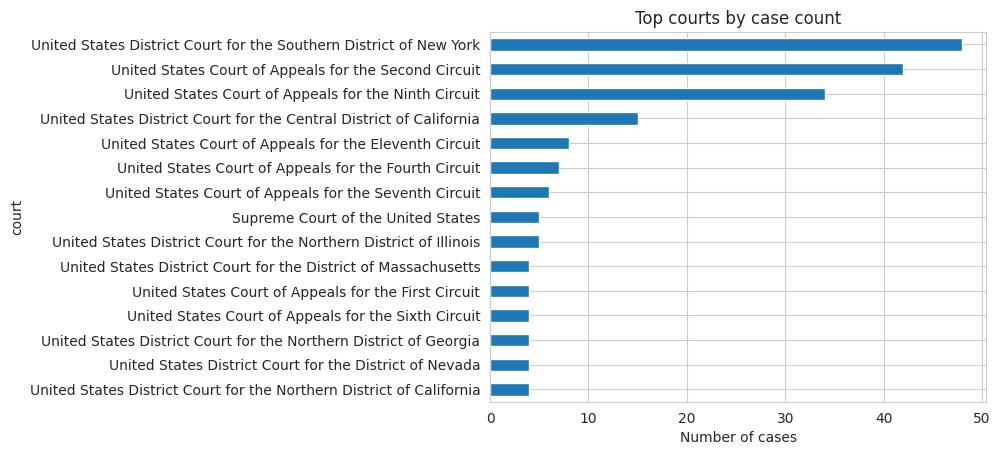


Courts with >= 5 cases: 9


In [87]:
court_counts = fair_use_findings["court"].value_counts()
print(court_counts.head(20))

top_k = 15
court_counts.head(top_k).sort_values().plot(kind="barh")
plt.title("Top courts by case count")
plt.xlabel("Number of cases")
plt.show()

min_court_n = 5
print(f"\nCourts with >= {min_court_n} cases:", (court_counts >= min_court_n).sum())

### Text readiness for topic modeling



Topic modeling requires consistent text inputs. This step constructs the modeling text by combining `key_facts` and `issue`, then checks missingness and length variation. Length distributions help justify basic preprocessing choices and highlight whether a small number of unusually long cases could dominate TF-IDF features.


       key_facts_wc    issue_wc     text_wc
count    251.000000  251.000000  251.000000
mean     122.195219   22.434263  144.629482
std       50.487441    8.928531   51.567065
min       33.000000   10.000000   57.000000
25%       84.500000   17.000000  107.500000
50%      111.000000   21.000000  134.000000
75%      149.500000   26.000000  172.000000
max      344.000000  109.000000  364.000000


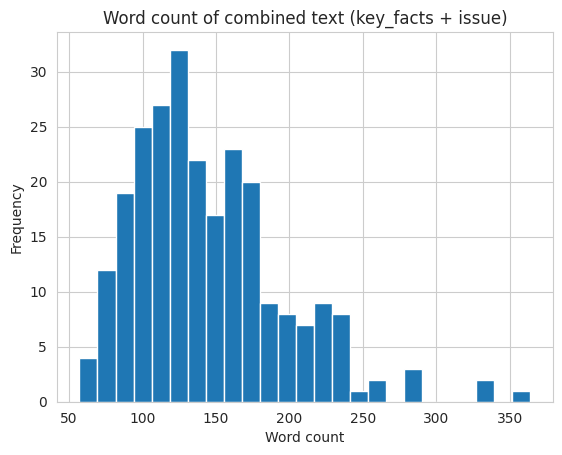

In [88]:
fair_use_findings["text"] = (
    fair_use_findings["key_facts"].fillna("").astype(str)
    + " "
    + fair_use_findings["issue"].fillna("").astype(str)
).str.strip()

fair_use_findings["key_facts_wc"] = (
    fair_use_findings["key_facts"].fillna("").astype(str).str.split().apply(len)
)
fair_use_findings["issue_wc"] = (
    fair_use_findings["issue"].fillna("").astype(str).str.split().apply(len)
)
fair_use_findings["text_wc"] = (
    fair_use_findings["text"].fillna("").astype(str).str.split().apply(len)
)

print(fair_use_findings[["key_facts_wc", "issue_wc", "text_wc"]].describe())

fair_use_findings["text_wc"].plot(kind="hist", bins=25)
plt.title("Word count of combined text (key_facts + issue)")
plt.xlabel("Word count")
plt.show()

### Baseline outcome patterns by court



Before controlling for dispute type, it is useful to establish the baseline relationship between court and outcome. This step summarizes the overall fair-use rate and compares courts at a high level. These baseline patterns are later revisited after topics and clusters define comparable case types.


                                                     n  fair_use_rate
court                                                                
United States District Court for the Southern D...  38       0.526316
United States Court of Appeals for the Second C...  31       0.419355
United States Court of Appeals for the Ninth Ci...  29       0.413793
United States District Court for the Central Di...  10       0.600000
United States Court of Appeals for the Fourth C...   6       0.833333
United States Court of Appeals for the Eleventh...   5       0.400000
United States District Court for the Northern D...   5       0.800000
United States Court of Appeals for the Seventh ...   5       0.400000
Supreme Court of the United States                   4       0.500000
United States District Court for the District o...   4       0.250000
United States Court of Appeals for the Sixth Ci...   4       0.250000
United States Court of Appeals for the First Ci...   4       0.500000
United States Distri

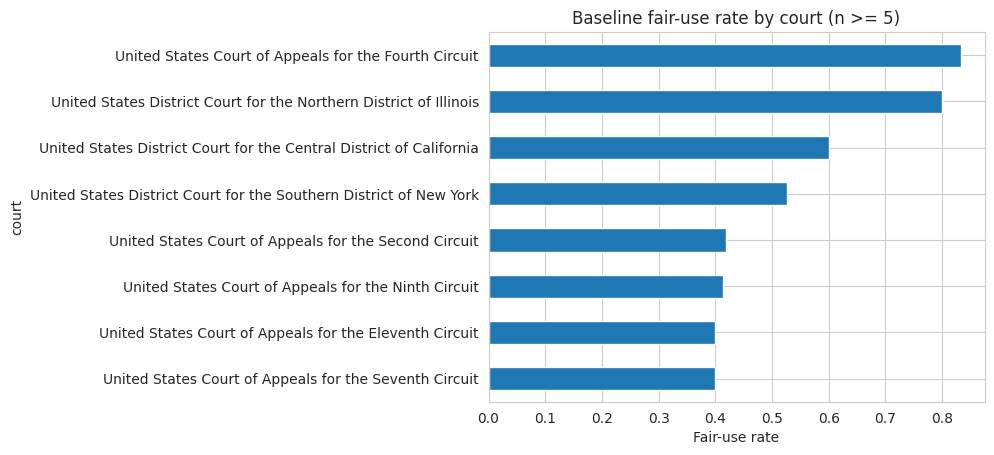

In [89]:
fair_use_findings_binary = fair_use_findings[
    fair_use_findings["outcome"].isin(["FAIR_USE_FOUND", "FAIR_USE_NOT_FOUND"])
].copy()

fair_use_findings_binary["fair_use_flag"] = (
    fair_use_findings_binary["outcome"] == "FAIR_USE_FOUND"
)

court_summary = (
    fair_use_findings_binary.groupby("court")["fair_use_flag"]
    .agg(n="count", fair_use_rate="mean")
    .sort_values("n", ascending=False)
)

print(court_summary.head(20))

min_court_n = 5
plot_df = court_summary[court_summary["n"] >= min_court_n].head(15).sort_values("fair_use_rate")
plot_df["fair_use_rate"].plot(kind="barh")
plt.title(f"Baseline fair-use rate by court (n >= {min_court_n})")
plt.xlabel("Fair-use rate")
plt.show()

In [90]:
fair_use_findings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   case_number   251 non-null    object
 1   year          250 non-null    Int64 
 2   court         251 non-null    object
 3   key_facts     251 non-null    object
 4   issue         251 non-null    object
 5   outcome       251 non-null    object
 6   text          251 non-null    object
 7   key_facts_wc  251 non-null    int64 
 8   issue_wc      251 non-null    int64 
 9   text_wc       251 non-null    int64 
dtypes: Int64(1), int64(3), object(6)
memory usage: 20.0+ KB


# Topic Modeling
First unsupervised or unstructured analysis method

The text input for topic modeling is constructed by combining key_facts and issue. These fields describe the dispute context and legal question, and they are used to define “case types” without leaking decision language from holding. Basic cleaning (lowercasing and whitespace normalization) is applied to reduce superficial variation before vectorization.

In [91]:
# Combine key facts + issue into one text field for topic modeling
fair_use_findings["text"] = (
    fair_use_findings["key_facts"].fillna("").astype(str) + " " +
    fair_use_findings["issue"].fillna("").astype(str)
)

# Basic cleaning: lowercase, collapse whitespace, trim
fair_use_findings["text"] = (
    fair_use_findings["text"]
    .str.lower()
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

Topic modeling is used to extract dispute themes from the combined key_facts + issue text. The primary approach uses NMF on a TF-IDF–weighted document–term matrix, which downweights common boilerplate terms and typically produces clearer and more distinct topic vocabularies, especially for short case summaries. NMF is fit using three different values of K to assess sensitivity to the number of topics, and the resulting topic-word summaries and per-case topic mixtures are compared for interpretability and stability to select a final configuration for later steps.

For completeness, LDA was also tested using a count-based representation, but the topics were largely driven by generic litigation language and showed high overlap, so it was not used in the main workflow. LDA may be revisited later with additional preprocessing or longer text inputs.

## Non-negative Matrix Factorization (NMF)

TF-IDF is used to downweight very common legal terms and emphasize terms that distinguish cases by fact patterns. NMF is then fit to the TF-IDF matrix to extract non-negative topic components, producing interpretable themes that can be treated as text-derived “case types.” These topic mixtures provide a compact numeric representation of each case summary for later analysis.

In [92]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# Define the number of topics (K) to investigate for NMF.
K_try = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

# Initialize TF-IDF vectorizer for text feature extraction.
tfidf_vec = TfidfVectorizer(
    stop_words="english",
    min_df=2,
    max_df=0.95,
    ngram_range=(1, 2)
)

# Transform text data into TF-IDF features.
X_tfidf = tfidf_vec.fit_transform(fair_use_findings["text"])
# Store the vocabulary terms for interpretation.
terms_tfidf = tfidf_vec.get_feature_names_out()

# Prepare to store NMF results for each K value.
nmf_results = {}

# Loop through each specified number of topics (K) to run NMF.
for K in K_try:
    # Set up the NMF model for the current K.
    nmf = NMF(n_components=K, random_state=42, init="nndsvda", max_iter=400)
    # Apply NMF to extract topic distributions per document.
    nmf_doc_topic = nmf.fit_transform(X_tfidf)

    # Record the model's output and key metrics for the current K.
    nmf_results[K] = {
        "model": nmf,
        "doc_topic": nmf_doc_topic,                 # (n_cases, K) topic weights per case
        "dominant_topic": nmf_doc_topic.argmax(1),  # length n_cases
        "reconstruction_err": nmf.reconstruction_err_,
        "terms": terms_tfidf
    }

    # Assign the dominant topic for the current K to the DataFrame.
    fair_use_findings[f"nmf_topic_k{K}"] = nmf_results[K]["dominant_topic"]

    # Report the reconstruction error for the NMF model at current K.
    print(f"NMF K={K} | recon_err={nmf_results[K]['reconstruction_err']:.4f}")

NMF K=2 | recon_err=15.3756
NMF K=4 | recon_err=15.1766
NMF K=6 | recon_err=15.0127
NMF K=8 | recon_err=14.8618
NMF K=10 | recon_err=14.7173
NMF K=12 | recon_err=14.5823
NMF K=14 | recon_err=14.4608
NMF K=16 | recon_err=14.3360
NMF K=18 | recon_err=14.2152
NMF K=20 | recon_err=14.1006


Knee K* = 10 (recon_err = 14.7173)


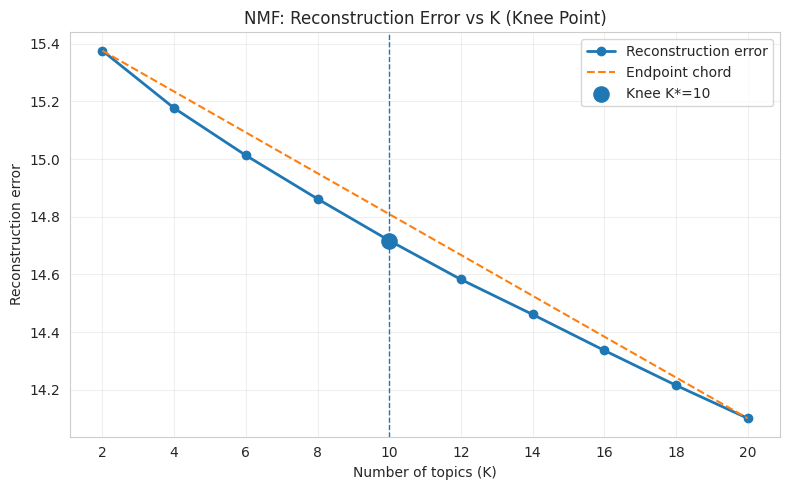

In [93]:
# Extract the sorted K values and corresponding reconstruction errors
Ks = np.array(sorted(nmf_results.keys()), dtype=float)
errs = np.array([nmf_results[int(k)]["reconstruction_err"] for k in Ks], dtype=float)

# Define the start and end points of the curve for the chord line
x1, y1 = Ks[0], errs[0]
x2, y2 = Ks[-1], errs[-1]

# Calculate the perpendicular distance of each point from the chord line
numer = np.abs((y2 - y1) * Ks - (x2 - x1) * errs + x2 * y1 - y2 * x1)
denom = np.sqrt((y2 - y1) ** 2 + (x2 - x1) ** 2)
dists = numer / denom

# Set distances at endpoints to -inf so they aren't selected as the knee
dists[0] = -np.inf
dists[-1] = -np.inf

# Identify the index of the maximum distance (the knee point)
knee_idx = int(np.argmax(dists))
knee_k = int(Ks[knee_idx])
knee_err = errs[knee_idx]

print(f"Knee K* = {knee_k} (recon_err = {knee_err:.4f})")

# Initialize the plot for visualization
plt.figure(figsize=(8, 5))

# Plot the reconstruction error curve
plt.plot(Ks, errs, marker="o", linewidth=2, label="Reconstruction error")

# Plot the chord line connecting the endpoints
plt.plot([x1, x2], [y1, y2], linestyle="--", linewidth=1.5, label="Endpoint chord")

# Highlight the identified knee point
plt.scatter([knee_k], [knee_err], s=120, zorder=3, label=f"Knee K*={knee_k}")
plt.axvline(knee_k, linestyle="--", linewidth=1)

# Add titles, labels, and grid to the plot
plt.title("NMF: Reconstruction Error vs K (Knee Point)")
plt.xlabel("Number of topics (K)")
plt.ylabel("Reconstruction error")
plt.xticks(Ks.astype(int))
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

The reconstruction error steadily decreases as the number of topics increases, which is expected because more topics give the model more flexibility to fit the data. However, the rate of improvement slows down after a point. The knee-point check highlights K = 10 as the point where the curve starts to flatten, meaning that moving beyond 10 topics provides only small reductions in error relative to the extra complexity. Choosing K = 10 is therefore a practical tradeoff: it captures meaningful variation in dispute themes while keeping the topic space small enough to interpret and use as stable “case-type” features in the later steps.

To compare interpretability across K values, the top words for each topic are printed. Topics that are easy to label and show minimal repetition across topics are preferred, since they provide clearer “case type” themes for later steps.

In [94]:
# Define the number of top words to display for each topic.
top_n = 10

# Iterate through each NMF model trained with different numbers of topics (K).
for K in K_try:
    # Retrieve the NMF model and the corresponding vocabulary terms for the current K.
    nmf = nmf_results[K]["model"]
    terms = nmf_results[K]["terms"]

    # Print a header for the current K to delineate the output.
    print(f"\nTop words per topic (NMF, K={K})")
    # For each topic generated by the NMF model, extract and display its most representative words.
    for topic_id, topic_weights in enumerate(nmf.components_):
        # Get the indices of the top 'top_n' words based on their weights in the current topic.
        top_idx = topic_weights.argsort()[::-1][:top_n]
        # Print the topic ID and the comma-separated list of its top words.
        print(f"Topic {topic_id}: " + ", ".join(terms[top_idx]))


Top words per topic (NMF, K=2)
Topic 0: plaintiff, defendant, defendants, plaintiffs, court, district, district court, works, copyright, book
Topic 1: photograph, article, post, photographs, website, photographer, copyright, media, instagram, posted

Top words per topic (NMF, K=4)
Topic 0: plaintiffs, defendants, film, song, works, video, music, copyright, infringement, films
Topic 1: photograph, post, article, photographs, website, photographer, instagram, copyright, media, posted
Topic 2: plaintiff, defendant, book, court, district, published, district court, appealed district, books, ruling
Topic 3: news, footage, lans, video, los angeles, angeles, los, service, defendant, plaintiff

Top words per topic (NMF, K=6)
Topic 0: defendants, film, song, video, plaintiffs, music, musical, documentary, parody, videos
Topic 1: photograph, post, article, copyright, instagram, new, blog, use photograph, posted, photographer
Topic 2: plaintiff, defendant, book, published, court, books, district

A second check is whether topic assignments produce sensible group sizes. Very small topics may be unstable and hard to interpret, while extremely large topics may be too broad. The dominant-topic counts are shown for each K to assess balance.

In [95]:
# Iterate through each NMF model (for different values of K)
for K in K_try:
    # Calculate the number of cases assigned to each dominant topic for the current K
    counts = fair_use_findings[f"nmf_topic_k{K}"].value_counts().sort_index()

    # Print the dominant topic counts and their minimum/maximum sizes
    print(f"\nDominant topic counts (NMF, K={K})")
    print(counts)
    print("Min topic size:", counts.min(), "| Max topic size:", counts.max())


Dominant topic counts (NMF, K=2)
nmf_topic_k2
0    203
1     48
Name: count, dtype: int64
Min topic size: 48 | Max topic size: 203

Dominant topic counts (NMF, K=4)
nmf_topic_k4
0     88
1     41
2    104
3     18
Name: count, dtype: int64
Min topic size: 18 | Max topic size: 104

Dominant topic counts (NMF, K=6)
nmf_topic_k6
0    43
1    33
2    81
3    14
4    53
5    27
Name: count, dtype: int64
Min topic size: 14 | Max topic size: 81

Dominant topic counts (NMF, K=8)
nmf_topic_k8
0    33
1    34
2    70
3    14
4    33
5    27
6    17
7    23
Name: count, dtype: int64
Min topic size: 14 | Max topic size: 70

Dominant topic counts (NMF, K=10)
nmf_topic_k10
0    20
1    31
2    56
3    12
4    25
5    26
6    16
7    26
8    15
9    24
Name: count, dtype: int64
Min topic size: 12 | Max topic size: 56

Dominant topic counts (NMF, K=12)
nmf_topic_k12
0     14
1     32
2     49
3     11
4     26
5     26
6     17
7     18
8     14
9     22
10    16
11     6
Name: count, dtype: int64
Mi

Across the full range of tested values (K = 2 to 20), the dominant-topic counts show a clear pattern: smaller K values create a few very broad buckets that mix multiple dispute themes, while larger K values increasingly split those buckets into narrower themes. This is useful for checking whether the model is producing usable “case types,” because extremely large topics usually signal over-broad themes, and extremely small topics can be unstable or too specific to interpret reliably.

The topic-size summaries support selecting K = 10 as a practical middle ground. At K = 10, topics are still distinct enough to label and interpret, and the distribution avoids both the heavy collapse seen at lower K and the very small niche topics that start to appear at higher K. Together with the knee-point result from the reconstruction-error curve, this makes K = 10 a reasonable choice for downstream case-type analysis.

### Viewing The Results

In [96]:
K = 10
W = nmf_results[K]["doc_topic"]  # shape: (n_cases, K)

topic_cols = [f"topic_{i}" for i in range(K)]

nmf_topic_weights_k10 = pd.DataFrame(W, columns=topic_cols)
nmf_topic_weights_k10.insert(0, "case_number", fair_use_findings["case_number"].values)

# Useful summary columns (kept inside this table, not added back to fair_use_findings)
nmf_topic_weights_k10["dominant_topic"] = W.argmax(axis=1)
nmf_topic_weights_k10["dominant_weight"] = W.max(axis=1)

nmf_topic_weights_k10.head(10)

,case_number,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,dominant_topic,dominant_weight
0,39 F.4th 1214 (9th Cir. 2022),0.041529,0.000000,0.000000,0.000000,0.225198,0.178476,0.000000,0.000000,0.028705,0.043319,4,0.225198
1,"No. CV 21-1102, 2022 WL 2784818 (C.D. Cal. May...",0.021433,0.135854,0.000000,0.000000,0.000000,0.000851,0.000000,0.065274,0.000000,0.013951,1,0.135854
2,"No. 19-CV-7470-LTS-VF, 2022 U.S. Dist. LEXIS 8...",0.062300,0.000000,0.000000,0.000000,0.000000,0.000000,0.167525,0.000000,0.025972,0.167756,9,0.167756
3,"No. 13-cv-1215 (TSC), 2022 U.S. Dist. LEXIS 60...",0.000000,0.012402,0.023487,0.000000,0.277498,0.026679,0.000000,0.039535,0.011493,0.011300,4,0.277498
4,"Nos. 20-4097-cv(L), 20-4201-cv (XAP), 2022 U.S...",0.000000,0.435800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014149,1,0.435800
5,"Civ. Action No H-21-2612, 2022 U.S. Dist. LEXI...",0.000000,0.009973,0.000000,0.004021,0.041133,0.004524,0.021205,0.005756,0.270322,0.000000,8,0.270322
6,"19 Civ. 9617 (KPF), 2022 U.S. Dist. LEXIS 5023...",0.000000,0.299204,0.000000,0.000000,0.000000,0.118378,0.000000,0.000000,0.000000,0.000000,1,0.299204
7,28 F.4th 314 (1st Cir. 2022),0.000000,0.183423,0.020887,0.000000,0.048423,0.000000,0.000000,0.051223,0.000000,0.007696,1,0.183423
8,27 F.4th 313 (5th Cir. 2022),0.000000,0.059604,0.085241,0.000000,0.000000,0.009576,0.000022,0.017786,0.016768,0.022853,2,0.085241
9,"No. 19 CIV. 9769 (AT), 2021 WL 4443259 (S.D.N....",0.000000,0.422517,0.000000,0.011960,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,0.422517


In [112]:
terms = nmf_results[10]["terms"]
H = nmf_results[10]["model"].components_  # shape: (K, n_terms)

top_n = 20
topic_labels_k10 = {}
for t in range(K):
    top_idx = np.argsort(H[t])[-top_n:][::-1]
    topic_labels_k10[t] = ", ".join(terms[top_idx])

pd.DataFrame({
    "topic": list(topic_labels_k10.keys()),
    "top_words": list(topic_labels_k10.values())
})

,topic,top_words
0,0,"defendants, plaintiff, advertisement, parody, ..."
1,1,"photograph, post, article, instagram, copyrigh..."
2,2,"defendant, plaintiff, book, court, published, ..."
3,3,"news, footage, lans, angeles, los, los angeles..."
4,4,"plaintiffs, works, university, factor, factors..."
5,5,"photographs, images, photos, gossip, celebrity..."
6,6,"film, documentary, films, clips, star, scenes,..."
7,7,"game, video, code, software, computer, program..."
8,8,"series, television series, television, charact..."
9,9,"song, music, musical, lyrics, defendants, albu..."


# Clustering

Second unsupervised or unstructured analysis method

Clustering is used to group cases into comparable “case types” based on dispute content rather than where the case was decided or how it turned out. Each case is represented only by its NMF topic-mixture weights (K=10) learned from the combined key_facts + issue text. Venue (court) and decision outcome are intentionally excluded to avoid leakage. The resulting clusters provide text-driven case-type groupings that can later be used to compare fair-use outcomes across courts while holding dispute type approximately constant.

For clustering, the feature matrix contains only the 10 topic-weight columns for each case. These features are already numeric and comparable across cases, but they are still standardized so that no single topic dimension dominates distance calculations due to scale differences. This produces a clean input for Hierarchical Clustering and K-means, and keeps the clustering interpretation tightly tied to dispute themes.

In [98]:
from sklearn.preprocessing import StandardScaler

# Retrieve the document-topic matrix from the NMF results for K=10
W = nmf_results[10]["doc_topic"]

# Apply standard scaling to the topic weights matrix
X_cluster = StandardScaler().fit_transform(W)

# Print the shape of the resulting feature matrix
print("X_cluster shape:", X_cluster.shape)

# Create a list of column names for the topics
cluster_cols = [f"topic_w{i}" for i in range(10)]

# Construct a DataFrame with the topic weights for inspection
cluster_df = pd.DataFrame(W, columns=cluster_cols)

# Display the first 5 rows of the DataFrame
cluster_df.head()

X_cluster shape: (251, 10)


,topic_w0,topic_w1,topic_w2,topic_w3,topic_w4,topic_w5,topic_w6,topic_w7,topic_w8,topic_w9
0,0.041529,0.000000,0.000000,0.0,0.225198,0.178476,0.000000,0.000000,0.028705,0.043319
1,0.021433,0.135854,0.000000,0.0,0.000000,0.000851,0.000000,0.065274,0.000000,0.013951
2,0.062300,0.000000,0.000000,0.0,0.000000,0.000000,0.167525,0.000000,0.025972,0.167756
3,0.000000,0.012402,0.023487,0.0,0.277498,0.026679,0.000000,0.039535,0.011493,0.011300
4,0.000000,0.435800,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.014149


## K-Means Clustering

K-means clustering is used to group cases into content-based “case types” using the standardized NMF (K=10) topic-weight features only. The first step is choosing the number of clusters, k. An elbow plot is used to see where adding more clusters yields diminishing improvements in within-cluster fit (inertia). This helps select a cluster count that balances simplicity and separation.

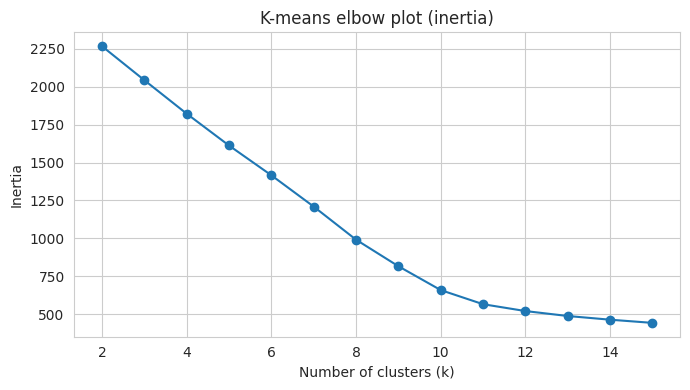

In [99]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Define range of k to test for the elbow plot
k_values = range(2, 16)
inertias = []

# Fit K-Means for each k and record inertia
for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    km.fit(X_cluster)
    inertias.append(km.inertia_)

# Plot inertia to identify the elbow
plt.figure(figsize=(7, 4))
plt.plot(list(k_values), inertias, marker="o")
plt.title("K-means elbow plot (inertia)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.tight_layout()
plt.show()

Based on the elbow plot, the rate of improvement slows noticeably around k = 10, so 10 clusters are used as a practical balance between coarse grouping and over-fragmentation. The K-means model is then fit on the standardized topic-weight features, and the resulting cluster label is saved as a case-type indicator. Cluster sizes are checked to confirm that groups are not implausibly tiny.

In [100]:
from sklearn.cluster import KMeans

# Choose k based on the elbow plot
k_final = 10

# Fit K-Means on standardized topic-weight features only
kmeans = KMeans(n_clusters=k_final, random_state=42, n_init=50)
fair_use_findings["case_type_cluster"] = kmeans.fit_predict(X_cluster)

# Check cluster sizes
print("Cluster sizes (k=10):")
print(fair_use_findings["case_type_cluster"].value_counts().sort_index())

Cluster sizes (k=10):
case_type_cluster
0    12
1    23
2    68
3    63
4    21
5     5
6    21
7    11
8     7
9    20
Name: count, dtype: int64


To evaluate how well-separated the clusters are, a silhouette plot is produced. Values closer to 1 indicate well-separated clusters, values near 0 indicate overlap, and negative values suggest cases may fit better in a different cluster.

Silhouette mean (k=10): 0.372


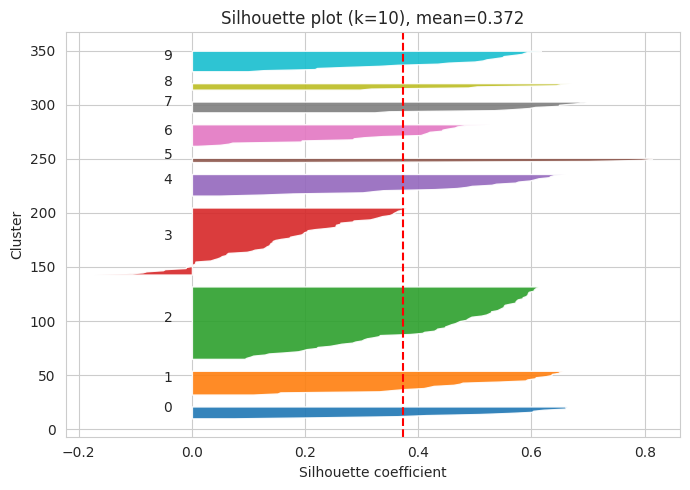

In [105]:
from sklearn.metrics import silhouette_samples, silhouette_score

k_final = 10

# Silhouette scores for the final clustering (topic weights only)
labels = fair_use_findings["case_type_cluster"].to_numpy()
sil_vals = silhouette_samples(X_cluster, labels)
sil_avg = silhouette_score(X_cluster, labels)

print(f"Silhouette mean (k={k_final}): {sil_avg:.3f}")

# Silhouette plot
plt.figure(figsize=(7, 5))
y_lower = 10

for c in sorted(np.unique(labels)):
    c_sil = np.sort(sil_vals[labels == c])
    size_c = len(c_sil)
    y_upper = y_lower + size_c

    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, c_sil, alpha=0.9)
    plt.text(-0.05, y_lower + 0.5 * size_c, str(c))

    y_lower = y_upper + 10

plt.axvline(sil_avg, color="red", linestyle="--", linewidth=1.5)
plt.title(f"Silhouette plot (k={k_final}), mean={sil_avg:.3f}")
plt.xlabel("Silhouette coefficient")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

For k = 10, the silhouette plot shows mostly positive scores with an average of about 0.37, which suggests the clusters are reasonably separated but not perfectly distinct. This is expected for short legal summaries where dispute themes can overlap, and it supports using k = 10 as a workable set of “case types” for downstream venue comparisons

## Hierarchical Clustering

Hierarchical clustering is used as a complementary, structure-first check on the case-type groupings. Unlike K-means, it does not require choosing the number of clusters upfront. Instead, it builds a tree of merges based on distances between cases in the standardized topic-weight space, which helps visualize whether the data naturally forms a few large groups or many smaller ones.

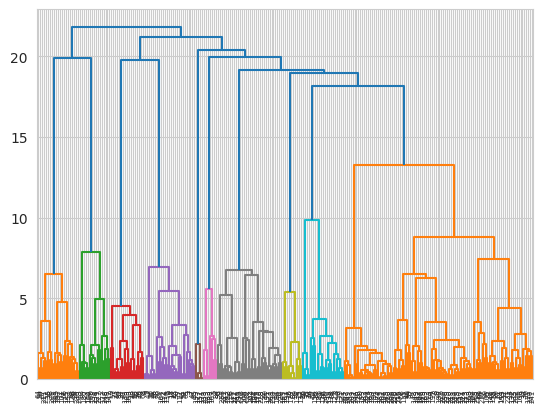

In [108]:
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage, fcluster

Z = linkage(X_cluster, method="ward")

_ = dendrogram(Z,)

The dendrogram shows many merges happening at low distances, meaning lots of cases are fairly similar in topic space. Only a few large jumps appear near the top, where broader groups are forced together.

This suggests dispute themes overlap rather than forming a few perfectly separate groups. A mid-sized cut (not 2–3 clusters) makes more sense, which is consistent with using k = 10 as a practical number of case-type groups.

In [111]:
n_clusters = 10

# Generate cluster labels using hierarchical clustering
# We assign them to the main DataFrame because X_cluster is a numpy array and doesn't support named columns
fair_use_findings['hierarchical_cluster'] = fcluster(Z, n_clusters, criterion='maxclust')

# Display the size of each hierarchical cluster
print("Hierarchical Cluster Sizes:")
print(fair_use_findings['hierarchical_cluster'].value_counts().sort_index())

Hierarchical Cluster Sizes:
hierarchical_cluster
1     21
2     16
3     17
4     26
5      4
6      7
7     33
8     10
9     21
10    96
Name: count, dtype: int64


To evaluate how well-separated the clusters are, a silhouette plot is produced. Values closer to 1 indicate well-separated clusters, values near 0 indicate overlap, and negative values suggest cases may fit better in a different cluster.

Silhouette mean (k=10): 0.352


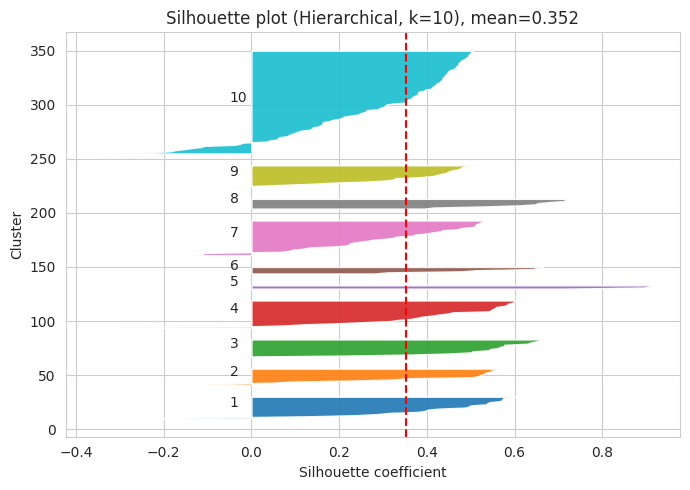

In [116]:
from sklearn.metrics import silhouette_samples, silhouette_score

k_final = 10

# Silhouette scores for the final clustering (topic weights only)
# Switched to use hierarchical_cluster labels as requested
labels = fair_use_findings["hierarchical_cluster"].to_numpy()
sil_vals = silhouette_samples(X_cluster, labels)
sil_avg = silhouette_score(X_cluster, labels)

print(f"Silhouette mean (k={k_final}): {sil_avg:.3f}")

# Silhouette plot
plt.figure(figsize=(7, 5))
y_lower = 10

for c in sorted(np.unique(labels)):
    c_sil = np.sort(sil_vals[labels == c])
    size_c = len(c_sil)
    y_upper = y_lower + size_c

    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, c_sil, alpha=0.9)
    plt.text(-0.05, y_lower + 0.5 * size_c, str(c))

    y_lower = y_upper + 10

plt.axvline(sil_avg, color="red", linestyle="--", linewidth=1.5)
plt.title(f"Silhouette plot (Hierarchical, k={k_final}), mean={sil_avg:.3f}")
plt.xlabel("Silhouette coefficient")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

For k = 10, the silhouette plot shows mostly positive scores with an average of about 0.35, which suggests the clusters are reasonably separated but not perfectly distinct. This is expected for short legal summaries where dispute themes can overlap, and it supports using k = 10 as a workable set of “case types” for downstream venue comparisons.

## Comparing Methods

In [117]:
from sklearn.metrics import silhouette_score

X  = X_cluster
km = fair_use_findings["case_type_cluster"].to_numpy()
hc = fair_use_findings["hierarchical_cluster"].to_numpy()

s_km = silhouette_score(X, km)
s_hc = silhouette_score(X, hc)

print(f"Silhouette  KMeans: {s_km:.3f} | Hier(Ward): {s_hc:.3f}")

Silhouette  KMeans: 0.372 | Hier(Ward): 0.352


Both methods produce reasonably separated case-type groupings using the same topic-weight features, but K-means performs slightly better by the silhouette metric. The average silhouette score is 0.372 for K-means versus 0.352 for hierarchical (Ward), indicating that K-means yields clusters that are, on average, more internally coherent and more distinct from neighboring clusters. Given this modest but consistent improvement, and because K-means also provides a direct, stable assignment of cases into a fixed number of groups, K-means is selected as the final clustering approach for defining case types in the downstream venue comparison.

# Analyzing Results